In [2]:
SEED=3012024

DEVICE = "cpu" # MacM2 processor is mps ,if CUDA is cuda

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple

torch.manual_seed(SEED)

### VAEs 

1. Bishop 10.4)

$p(X)$ is a fixed distribution and we approximate is using $q(X)=\mathcal{N}(x|\mu,\Sigma)$. 

The KL divergence $KL(p||q)$ for the Gaussian $q(X)$ is then 
$KL(p||q)=-\int_{-\infty}^{\infty}p(X)\log(\frac{p(X)}{q(X)})dx\Leftrightarrow -\int_{-\infty}^{\infty} p(X)(\log(p(X))-\log(\mathcal{N}(x|\,u,\Sigma)))dx$.

We introduce the latent $z$:
$-\int_{-\infty}^{\infty} \frac{p(X,z)}{p(z|x)}(\log(\frac{p(X,z)}{p(z|X)})-\log(q(X)))dx$.


Minimizing the KLD leads to $\mu$ given by the expectation of $X$ under $p(X)$ and $\Sigma$ by the covariance, since
for the mean $\mu$:

$\frac{\partial}{\partial_\mu} q(X)=\Sigma^{-1}(X-\mu)q(X)=\Sigma^{-1}(X-\mu)\mathcal{N}(x|\mu,\Sigma)=\int p(X)\Sigma^{-1}(X-\mu)dx = \int p(X) \Sigma^{-1} \mu - \Sigma^{-1} X dx = \Sigma^{-1} \mu - \Sigma^{-1} E[X] = 0 \Leftrightarrow \mu = E[X]$.

With $\mu = E[X]$:

$\frac{d}{d\Sigma}KL(p||q) = 0 \Leftrightarrow \Sigma = E[XX^T] - \mu \mu^T = E[XX^T] - E[X]E[X]^T = cov(X)$

Note that many intermediate steps are left out. And a lot of matrix calculations are needed.

In [3]:
## using the provided resource as base architecture
class VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super().__init__()
        assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device
        # define IO
        self.in_layer = nn.Linear(data_dim, hidden_dims[0])
        self.out_layer = nn.Linear(hidden_dims[-1], data_dim)
        # hidden layer
        self.enc_h = nn.Linear(hidden_dims[0], hidden_dims[1])
        # define hidden and latent
        self.enc_mu = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.enc_sigma = nn.Linear(hidden_dims[1], hidden_dims[2])
        # hidden layer decoder
        self.dec_h = nn.Linear(hidden_dims[2], hidden_dims[-2])
        self.dec_layer = nn.Linear(hidden_dims[-2], hidden_dims[-1])
        self.to(device)
        
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        return torch.sigmoid(self.out_layer(h4))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
def train(model: VAE, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BCE={ce} KLD={kld}")
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [5]:
def test(model: VAE, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, mu, logvar = model(x)
            test_loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [6]:
# lets use torch datasets with our data
class DatasetWrapper(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [12]:
## load the MNIST data we've used previously
## use torch dataloader object for the heavy lifting

mnist_train = np.loadtxt("./data/mnist_train.csv", delimiter=",", dtype=np.float32)
mnist_test = np.loadtxt("./data/mnist_test.csv", delimiter=",", dtype=np.float32)
train_labels = mnist_train[:,0]
train_data = mnist_train[:,1:] / 255
test_labels = mnist_test[:,0]
test_data = mnist_test[:,1:] / 255 # NOTE: don't forget to standardize

train_data.shape, test_data.shape

train_ds = DatasetWrapper(train_data, train_labels)
test_ds = DatasetWrapper(test_data, test_labels)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

In [28]:
EPOCHS=10

# 3.) modify the network architecture and try to obtain a better embedding
model = VAE(hidden_dims=[300, 50, 2, 50, 300]) # NOTE: 2D latent space
optimizer = optim.Adam(model.parameters(), lr=1e-3)
def logC(x, eps=1e-5):
    x = torch.clamp(x, eps, 1-eps)
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    # How I understand it should be
    far_values = torch.log((2. * torch.arctanh(1. - 2.*far)).div(1. - 2.*far))
    close_values = torch.log(2.*torch.ones(close.shape[0]))
    # Code found on https://github.com/Robert-Aduviri/Continuous-Bernoulli-VAE/blob/master/utils.py (Using second-order taylor approximation of C)
    # far_values = torch.log((torch.log(1. - far) - torch.log(far)).div(1. - 2. * far))
    # close_values = torch.log(torch.tensor(2.)) + torch.log(1. + torch.pow(1. - 2. * close, 2)/3.)
    return far_values.sum() + close_values.sum()

def loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    LOGC = -logC(recon_x)
    return BCE + LOGC + KLD, BCE, KLD # = -ELBO


train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train(model, epoch=e, train_loader=train_loader)
    test_loss_vals = test(model, epoch=e, test_loader=test_loader)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)

torch.Size([21])
Train epoch=1 [0/60000]	 loss=-0.14610621333122253
BCE=69700.2265625 KLD=2.5640296936035156
torch.Size([19])
torch.Size([19])
torch.Size([11])
torch.Size([9])
torch.Size([8])
torch.Size([6])
torch.Size([4])
torch.Size([3])
torch.Size([0])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([0])
torch.Size([0])
torch.Size([1])
torch.Size([0])
torch.Size([0])
torch.Size([0])
torch.Size([1])
torch.Size([0])
torch.Size([1])
torch.Size([0])
torch.Size([0])
torch.Size([0])
torch.Size([0])
Train epoch=1 [3200/60000]	 loss=-961.9313354492188
BCE=64794.0234375 KLD=5559.49951171875
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([2])
torch.Size([2])
torch.Size([3])
torch.Size([2])
torch.Size([1])
torch.Size([1])
torch.Size([0])
torch.Size([1])
torch.Size([2])
torch.Size([0])
torch.Size([2])
torch.Size([0])
torch.Size([1])
torch.Size([0])
torch.Size([0])
torch.Size([0])
torch.Size([1])
torch.Size([0])
torch.Size([1])
torch.Size([0])
torch.Size([0

KeyboardInterrupt: 

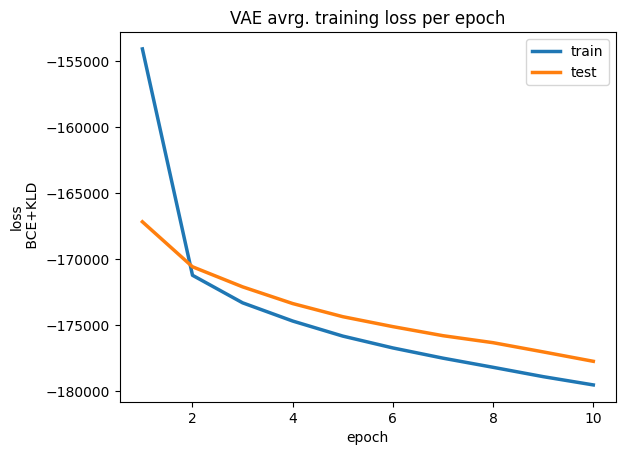

In [27]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

In [97]:
# encode entries
latent_coordinates = []
for data in train_data:
    # NOTE: we only obtain the mean for encoding and discard the log var
    latent_coordinates.append(model.encode(torch.Tensor(data).to(DEVICE))[0].cpu().detach().numpy())
latent_coordinates = np.array(latent_coordinates)


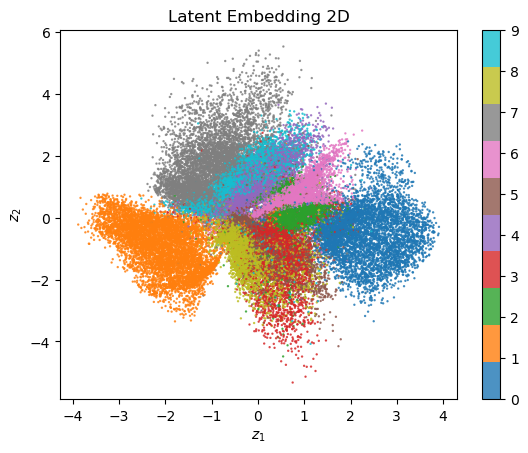

In [98]:
# visualize 2D embedding of MNIST
plt.scatter(latent_coordinates[:,0], latent_coordinates[:,1], alpha=.8, s=0.5, c=train_labels, cmap="tab10")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.colorbar()
plt.title("Latent Embedding 2D")
plt.show()

Compared to the PPCA we obtain better spatial separation. 
Numbers of the same label are grouped together in coherent clusters.


The architecture is modified by introducing another hidden layer in the encoder and decoder.

### Visualization by Gauss CDF

In [99]:
## 2.) visualize across Gaussian CDF
n_cols = 12
z_space = torch.linspace(0.0001, 0.9999, n_cols) # for 5x5 grid
std_gauss = torch.distributions.normal.Normal(0, 1)

xx, yy = torch.meshgrid(z_space, z_space)

zz_gauss_cdf_vals = torch.dstack([std_gauss.icdf(xx), std_gauss.icdf(yy)]).reshape(-1, 2)
zz_gauss_cdf_vals.shape

torch.Size([144, 2])

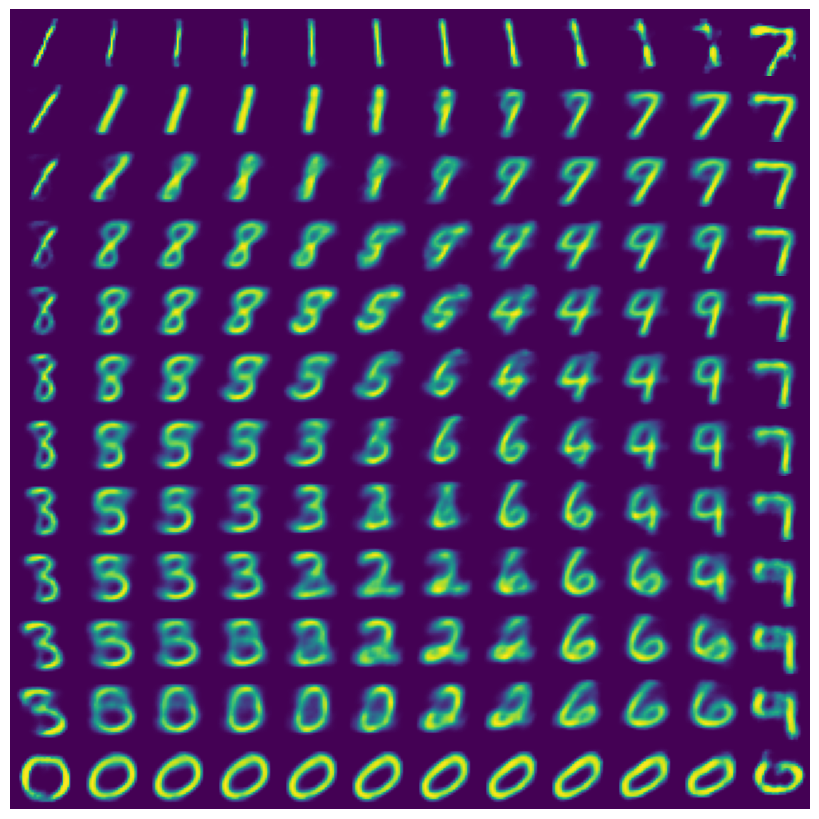

In [100]:
fig, ax = plt.subplots(nrows=n_cols, ncols=n_cols, figsize=(8,8))

k = 0
for i in range(n_cols):
    for j in range(n_cols):
        _zz = zz_gauss_cdf_vals[k]
        reconstruction = model.decode(_zz.to(DEVICE)).cpu().detach().numpy()
        img = reconstruction.reshape((28,28))
        ax[i, j].imshow(img)
        ax[i, j].set_axis_off()
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        k += 1
# plt.suptitle("MNIST reconstruction")
plt.tight_layout(w_pad=0., pad=0., h_pad=0.)
plt.show()
